<a href="https://colab.research.google.com/github/leoliuuu/PokerCardClassification/blob/main/PokerCards_w_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poker Card Classification using Transfer Learning with ResNet
Richard Gao & Leo Liu

ML 2019 Module 1 Project

## Project Journey
To start off the project, our team began with a basic one layer CNN attempting to classify all 52 classes representing each card individually. As expected, with all 52 classes, we had barely any accuracy rate at values ranging between ~0-5%. After tuning different parameters, including learing rate, epoch number, batch size, we had slight improvement. In order to significantly improve our model and accuracy, our team then decided to set up two different nets, one for suite classification, and the other for number classification. As a result, the suite classification had an accuracy rate around 55%, while the number classification only had an accuracy rate around 8% since there are a lot more classes in numbers. To further advance our model and hope to dramatically improve the accuracy, we decided to use transfer learning with the ResNet18 Architecture. After applying the transfer learning, the suite accuracy dramatically went up to nearly 97%, and the number accuracy went up to around 36%. Since our dataset is relatively small and there is still room in memory, we increased the image dimensions so that the images will have a greater resolution.  





## Installing Dependencies and Dataset

In [ ]:
!pip install torchviz
import gdown, os, shutil
from collections import defaultdict
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import time, random, math, numpy as np # we always love numpy
from torchvision import models
import copy

     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=bc11c5e20a871c6d38d339eab3f814fd61faeabec4f18cf5e6464b08f86f880f
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


Download the playing card dataset

In [ ]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1kWLhxjrjkQt8gOmsP63NgnFC2Vgna9mw&export=download', 'playing_cards_master.zip', quiet=False)
!unzip -qq playing_cards_master.zip

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1kWLhxjrjkQt8gOmsP63NgnFC2Vgna9mw&export=download
To: /content/playing_cards_master.zip
529MB [00:02, 208MB/s]


## Setting up Dataset for Classification

We split up the dataset into two directories containing classes for card suits and numbers independently. We follow the file directory structure specified for creating PyTorch `ImageFolder` objects with a root directory and one subdirectory for each class containing the repective images.

In [ ]:
source_path = './playing-cards-master/'
dest_path_s = './suits/' 
dest_path_n = './numbers/'

In [ ]:
if os.path.exists(source_path):
  cards = os.listdir(source_path)

  # Determine suit and number classes within img directory
  classes_s = set()
  classes_n = set()
  indexes_s = defaultdict(list)
  indexes_n = defaultdict(list)
  for idx, card in enumerate(cards):
    if '[' in card and ']' in card:
      start = card.find('[')
      end = card.find(']')
      c = card[start+1:end]
      # Add suit and number to respective sets and remember the card indexes
      suit, num = c[0], c[1]
      if num == '0': # Correctly label cards numbered 10
        num = '10'
      classes_s.add(suit)
      classes_n.add(num)
      indexes_s[suit].append(idx)
      indexes_n[num].append(idx)

  # Create suit directories
  os.mkdir(dest_path_s)
  for s in classes_s:
    if not os.path.exists(dest_path_s + s): 
      os.mkdir(dest_path_s + s)

  # Create number directories
  os.mkdir(dest_path_n)
  for n in classes_n:
    if not os.path.exists(dest_path_n + n): 
      os.mkdir(dest_path_n + n)

  # Move suit images to corresponding directory
  for key, values in indexes_s.items():
    for i in values:
      shutil.copy(source_path+'/'+cards[i], dest_path_s+key)

  # Move number images to corresponding directory
  for key, values in indexes_n.items():
    for i in values:
      shutil.copy(source_path +'/'+cards[i],dest_path_n+key)
  
  # Delete img directory
  shutil.rmtree(source_path)

## Data Cache

We use CachedDataset in place of ImageFolder to cache each image in memory after each transform so that training speed is magnitudes faster.

In [ ]:
# Datasets must always subclass either Dataset (either directly or indirectly)
# Here, we use subclass the ImageFolder class.
class CachedDataset(ImageFolder):
  def __init__(self, root, move_to_GPU=False, transform=None, target_transform=None):
      """ The init method passes most arguments up to the `ImageFolder` class.

          The exception is the `move_to_GPU` input, which if set to true will
          move the returned data to CUDA and if false, will keep it on the CPU
      """
      # make sure to call the super class init method
      super(CachedDataset, self).__init__(root,
                                          transform=transform,
                                          target_transform=target_transform)
      self.total_time_loading = 0
      self.move_to_GPU = move_to_GPU
      # we'll cache the loaded tensors here
      self.tensor_cache = {}

  def __getitem__(self, index):
      """
      Args:
          index (int): Index
      Returns:
          tuple: (image, target) where target is index of the target class.
      """
      t_start = time.time()
      if int(index) in self.tensor_cache:
          self.total_time_loading += time.time() - t_start
          return self.tensor_cache[int(index)]

      inputs, target = super(CachedDataset, self).__getitem__(index)
      if self.move_to_GPU:
          self.tensor_cache[int(index)] = inputs.to('cuda'), target
      else:
          self.tensor_cache[int(index)] = inputs, target
      self.total_time_loading += time.time() - t_start
      return self.tensor_cache[int(index)]

Image dimensions for transforms

In [ ]:
size = 400
image_dims = [3, size, size]

In [ ]:
playing_cards_s = CachedDataset(root='./suits',transform=transforms.Compose([
  transforms.Resize(size+1),
  transforms.CenterCrop(size),
  transforms.ToTensor()
]))

In [ ]:
playing_cards_n = CachedDataset(root='./numbers',transform=transforms.Compose([
  transforms.Resize(size+1),
  transforms.CenterCrop(size),
  transforms.ToTensor()
]))

There are 208 total images in our dataset

In [ ]:
len(playing_cards_s)

208

There are 4 classes for each suit (club, diamond, heart, and spade), and 13 classes for each number (2-10 and J, Q, K, A)

In [ ]:
print(len(playing_cards_s.classes), len(playing_cards_n.classes))

4 13


## Visualizing our Dataset

In [ ]:
def show_image(img_tensor):
  # need to reorder the tensor dimensions to work properly with imshow
  plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
  plt.axis('off')
  plt.show()

Visualizing one card

Suit
Card class: C
Image shape: torch.Size([3, 400, 400])


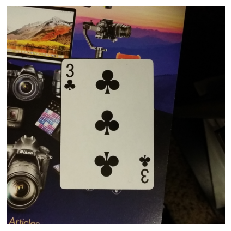

Number
Card class: 10


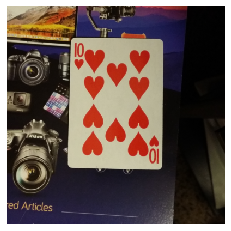

In [ ]:
print('Suit')
im, target = playing_cards_s[10]
print('Card class: ' + playing_cards_s.classes[target])
print('Image shape: ' + str(im.shape))
show_image(im)

print('Number')
im, target = playing_cards_n[10]
print('Card class: ' + playing_cards_n.classes[target])
show_image(im)

Visualizing a batch of cards

In [ ]:
def show_batch(images:CachedDataset, rows:int=5, figsize:tuple=(20,20)):
  fig, ax = plt.subplots(rows, rows, figsize=figsize)
  for i, im in enumerate(random.sample(range(len(images)), rows**2)):
      ax = plt.subplot(rows, rows, i+1)
      plt.title(images.classes[images[im][1]])
      plt.subplots_adjust(hspace=.2)
      ax.imshow(images[im][0].transpose(0,2).transpose(0,1))
      plt.axis('off')
      ax.set_axis_off()
  plt.show()

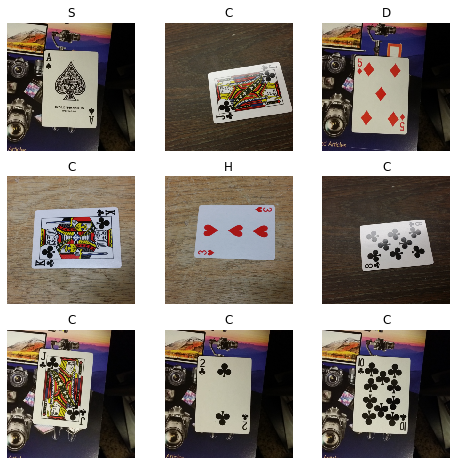

In [ ]:
show_batch(playing_cards_s, rows=3, figsize=(8,8))

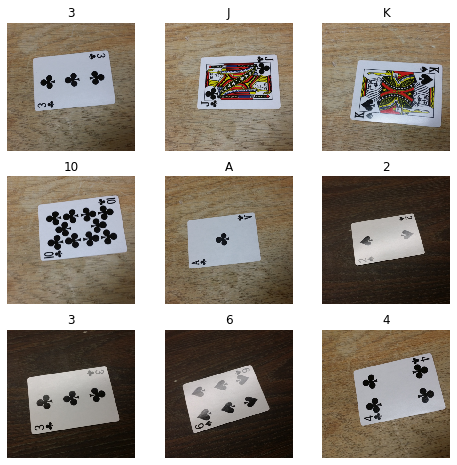

In [ ]:
show_batch(playing_cards_n, rows=3, figsize=(8,8))

The cards seem to be properly labeled and the transforms well done.

## Training/Validation Dataset Split

We get the indicies for splitting the `playing_cards` dataset into a training set and a testing set. To do this we use a stratified split from `sklearn` so that we maintain a proportion of 75% of images into the training and 25% of images into the testing with at least one of each card.

In [ ]:
# https://discuss.pytorch.org/t/how-to-split-test-and-train-data-keeping-equal-proportions-of-each-class/21063/6
s = StratifiedShuffleSplit(n_splits=1, test_size=.25)
split_s = s.split(playing_cards_s.imgs, playing_cards_s.targets)
train_idx_s, test_idx_s = next(split_s)
split_n = s.split(playing_cards_n.imgs, playing_cards_n.targets)
train_idx_n, test_idx_n = next(split_n)

We create training and testing dataset subsets. We do this instead of using `SubsetRandomSampler` to pass into the `Dataloader` because we found doing so would not ensure deterministic results in the `test_loader` -> [example 1](https://github.com/pytorch/pytorch/issues/7209), [example 2](https://discuss.pytorch.org/t/dataloader-is-not-deterministic/19250), [example 3](https://github.com/pytorch/pytorch/issues/7068). What this means is that with a sampler everytime we used the test_loader, we would get a different order of images. We need to have a fixed and consistent testing set so that we can evaluate and determine when our model improves when tweaking hyper-parameters. Therefore we set a seed and use dataset subsets.


In [ ]:
train_set_s = Subset(playing_cards_s, train_idx_s)
test_set_s = Subset(playing_cards_s, test_idx_s)

train_set_n = Subset(playing_cards_n, train_idx_n)
test_set_n = Subset(playing_cards_n, test_idx_n)

# Define training parameters
batch_size = 32

# Get our data into the mini batch size that we defined
train_loader_s = torch.utils.data.DataLoader(train_set_s, batch_size=batch_size, shuffle=True)
test_loader_s = torch.utils.data.DataLoader(test_set_s)

train_loader_n = torch.utils.data.DataLoader(train_set_n, batch_size=batch_size, shuffle=True)
test_loader_n = torch.utils.data.DataLoader(test_set_n)

## Transfer Learning and ResNet

We use transfer learning to take advantage of an already trained, well generalized deep learning model and apply it to our problem of poker card classification. We decided to use ResNet18 and break our problem into two separate models--one model to classify suit, and one model to classify number. This way instead of training a model to classify between 52 classes, we train two models with 4 and 13 classes.

We set up the functions to train our model.

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
def get_optimizer(model):
  params_to_update = model.parameters()
  # print("Params to learn:")
  params_to_update = []
  for name,param in model.named_parameters():
      if param.requires_grad == True:
          params_to_update.append(param)
          # print("\t",name)
  return optim.Adam(params_to_update, lr=0.001)

In [ ]:
def train_model(model, dataloaders, num_classes, num_epochs=20):
  since = time.time()

  val_acc_history = []
  train_hist_x = []
  train_loss_hist = []
  test_hist_x = []
  test_loss_hist = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  optimizer = get_optimizer(model)
  loss_func = nn.CrossEntropyLoss()

  print_every = 20
  idx = 0
  
  for epoch in range(num_epochs):
      batch_num = 0

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              #print(phase, "processing batch", batch_num)
              batch_num += 1
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  # Get model outputs and calculate loss
                  outputs = model(inputs)
                  loss = loss_func(outputs, labels)

                  _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

              idx += 1

          epoch_loss = running_loss / len(dataloaders[phase].sampler)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler)
          
          if (epoch % print_every) == print_every-1:
            if phase == 'train':
              print('Epoch {}/{}'.format(epoch, num_epochs - 1))
              print('-' * 10)

              train_loss_hist.append(epoch_loss)
              train_hist_x.append(idx)
            else:
              test_loss_hist.append(epoch_loss)
              test_hist_x.append(idx)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history, train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [ ]:
# this function freezes the weights of the network, unless we are not in
# feature extracting mode.  The last layer (the one we will train) is added
# after this function is called (so its weights will not be frozen)
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

We define our two models using ResNet18 for classifying suits and numbers.

In [ ]:
transfer_s = models.resnet18(pretrained=True)
set_parameter_requires_grad(transfer_s, feature_extract)
num_ftrs_s = transfer_s.fc.in_features
transfer_s.fc = nn.Linear(num_ftrs_s, len(playing_cards_s.classes))
print(transfer_s)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 29.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
transfer_n = models.resnet18(pretrained=True)
set_parameter_requires_grad(transfer_n, feature_extract)
num_ftrs_n = transfer_n.fc.in_features
transfer_n.fc = nn.Linear(num_ftrs_n, len(playing_cards_n.classes))
print(transfer_n)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = 'cuda'

# Send the model to GPU
transfer_s = transfer_s.to(device)
transfer_n = transfer_n.to(device)

We train the suit network for 100 epochs.

In [ ]:
transfer_s, val_acc, train_hist_x_s, train_loss_hist_s, test_hist_x_s, test_loss_hist_s = train_model(transfer_s, {'train': train_loader_s, 'val': test_loader_s}, len(playing_cards_s.classes), num_epochs=100)

Epoch 19/99
----------
train Loss: 0.4844 Acc: 0.9423
val Loss: 0.5428 Acc: 0.8269


We train the number network for 200 epochs.

In [ ]:
transfer_n, val_acc, train_hist_x_n, train_loss_hist_n, test_hist_x_n, test_loss_hist_n = train_model(transfer_n, {'train': train_loader_n, 'val': test_loader_n}, len(playing_cards_n.classes), num_epochs=200)

## Interpretation

### Showing Model Predictions

In [ ]:
def disp_image(dataset, image, class_idx, predicted=None):
  # need to reorder the tensor dimensions to work properly with imshow
  plt.imshow(image.transpose(0,2).transpose(0,1))
  plt.axis('off')
  if not predicted is None:
      plt.title("Actual: " + dataset.classes[class_idx] + "     Predicted: " + dataset.classes[predicted])
  else:
      plt.title("Actual: " + dataset.classes[class_idx])
  plt.show()

In [ ]:
def test_model(dataset, net, idx):
  image, label = dataset[idx]
  class_scores = net(Variable(image.unsqueeze(0)).to(device))
  prediction = np.argmax(class_scores.cpu().detach().numpy())
  disp_image(dataset, image, label, prediction)

Testing some inferences with the suit and number networks.

In [ ]:
test_model(playing_cards_s, transfer_s, 26)
test_model(playing_cards_n, transfer_n, 200)

### Computing accuracy of the model

In [ ]:
def get_accuracy(net, loader):
  n_correct = 0
  n_total = 0
  for i, data in enumerate(loader, 0):
      # Get inputs in right form
      inputs, labels = data
      inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

      # Forward pass
      outputs = net(inputs)
      n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
      n_total += labels.shape[0]
  return n_correct/n_total

Suit Net accuracy

In [ ]:
print("Train accuracy is", get_accuracy(transfer_s, train_loader_s))
print("Test accuracy is", get_accuracy(transfer_s, test_loader_s))

Number Net accuracy

In [ ]:
print("Train accuracy is", get_accuracy(transfer_n, train_loader_n))
print("Test accuracy is", get_accuracy(transfer_n, test_loader_n))

### Define interpretation functions

We define functions to interpret the results of the models. These tell us where the model is confused and how the training performed.

In [ ]:
import torch.nn.functional as F

# https://discuss.pytorch.org/t/efficient-method-to-gather-all-predictions/8008/5
def get_preds(model, test_loader):
  '''
  Make prediction from a pytorch model 
  '''
  # set model to evaluate model
  model.eval()
  
  y_true = torch.tensor([], dtype=torch.long, device=device)
  all_outputs = torch.tensor([], device=device)
  top_losses = []

  loss = nn.CrossEntropyLoss()
  img_idxes = test_loader.dataset.indices 
  
  # deactivate autograd engine and reduce memory usage and speed up computations
  with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        outputs = model(inputs)
        y_true = torch.cat((y_true, labels), 0)
        all_outputs = torch.cat((all_outputs, outputs), 0)
        # top_losses stores in a tuple the loss, img_idx w/ respect to playing_cards, and index that connects this loss value tothe other predictions
        top_losses.append((loss(outputs, labels).data.item(), img_idxes[i], i))
  
  y_true = y_true.cpu().numpy()  
  _, y_pred = torch.max(all_outputs, 1)
  y_pred = y_pred.cpu().numpy()
  y_pred_prob = [max(i) for i in F.softmax(all_outputs, dim=1).cpu().numpy()]
  top_losses.sort(reverse=True)
    
  return y_true, y_pred, y_pred_prob, top_losses

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.pyplot import figure

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          figsize=(15, 15)):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if not title:
      if normalize:
          title = 'Normalized confusion matrix'
      else:
          title = 'Confusion matrix, without normalization'

  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  # Only use the labels that appear in the data
  classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  #     print("Normalized confusion matrix")
  # else:
  #     print('Confusion matrix, without normalization')

  # print(cm)

  fig, ax = plt.subplots(figsize=figsize)
  # plt.rcParams['figure.figsize'] = [500, 500]
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          # ... and label them with the respective list entries
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel='Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  return ax

In [ ]:
def plot_top_losses(dataset, y_true, y_pred, y_pred_prob, top_losses, k=9, figsize=(12,12)):
  cols = math.ceil(math.sqrt(k))
  rows = math.ceil(k/cols)
  fig, ax = plt.subplots(cols, rows, figsize=figsize)
  fig.suptitle('Prediction/Actual/Loss/Probability', weight='bold', size=14)

  classes = dataset.classes

  top_losses = top_losses[:k]
  losses, img_idxes, pred_idxes = zip(*top_losses)

  for i in range(len(img_idxes)):
    pred_i = pred_idxes[i]

    ax = plt.subplot(cols, rows, i+1)
    plt.title(f'{classes[y_pred[pred_i]]} / {classes[y_true[pred_i]]} / {losses[i]:.2f} / {y_pred_prob[pred_i]:.2f}')
    ax.imshow(dataset[img_idxes[i]][0].transpose(0,2).transpose(0,1))
    plt.axis('off')
    ax.set_axis_off()

  plt.show()

### Visualizations

Plotting training and validation loss

In [ ]:
def plot_loss(net_name, train_hist_x, train_loss_hist, test_hist_x, test_loss_hist):
  plt.plot(train_hist_x, train_loss_hist)
  plt.plot(test_hist_x, test_loss_hist)
  plt.legend(['train loss', 'validation loss'])
  plt.xlabel('Batch number')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss for ' + net_name)
  plt.show()

In [ ]:
plot_loss('Suit Net', train_hist_x_s, train_loss_hist_s, test_hist_x_s, test_loss_hist_s)

Looking at the plot, it looks like the model can be trained slightly more as validation loss is still going down. However, train loss has become more flatlined, indicating the model may have fit too well to the training data.

In [ ]:
plot_loss('Number Net', train_hist_x_n, train_loss_hist_n, test_hist_x_n, test_loss_hist_n)

Analyzing the training and validation loss, it looks like the validation loss is flatlining or maybe even curving upwards, nearing overfitting. Some potential ideas to combat this is to increase the size of our database so that the model has more pictures to learn over so it will generalize better, and to look into dropout layers. 

We get predictions of the testing set using the suit network. We use this to get a better understanding of what the model is inappropriately labeling. 

In [ ]:
y_true, y_pred, y_pred_prob, top_losses = get_preds(transfer_s, test_loader_s)

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=np.asarray(playing_cards_s.classes),
                      title='Suit Confusion matrix', figsize=(5,5))

Since most predictions are along the diagonal, the model is doing pretty well. The only conusions are predicting 2 hearts as diamonds and predicting a club as a spade. These are reasonable inaccuracies as those suits are of the same color and they do look the same when the resolution is not high enough.

In [ ]:
plot_top_losses(playing_cards_s, y_true, y_pred, y_pred_prob, top_losses, figsize=(8,8))

It looks like for the top losses, the glare of the card may play a part in the mistaken prediction. An idea is to try normalizing the images to get rid of this.

We get predictions of the testing set using the number network.

In [ ]:
y_true, y_pred, y_pred_prob, top_losses = get_preds(transfer_n, test_loader_n)

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=np.asarray(playing_cards_n.classes),
                      title='Number Confusion matrix', figsize=(5,5))

Because most predictions are generally along the diagonal, the model is doing decently. There is more variance than the suit model, and it looks like the model gets confused between cards with numbers that are close in value. This is a reasonable error.

In [ ]:
plot_top_losses(playing_cards_n, y_true, y_pred, y_pred_prob, top_losses, figsize=(8,8))

The model seems to have difficulty accurately determining the exact number though it gets close most of the time. This can be due to the difficulty of the task at hand as the numbers exist only in the top left and bottom right corners of the card, and the number of suit images in the face of the card changes visually with each suit. Instead a more complex model like an R-CNN or YOLO model isolated to detect, locate, and classify a small bounding box on the corners of the card may allow for more accurate results.